**Import Necessary Modules**

In [1]:
#Import tensorflow and other necessary modules for Classification of Images
%tensorflow_version 1.14
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


**Mount your Google drive to Google Colab**

In [2]:
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Image Data Generator**       
 
1.   The Image Data Generator class is very useful in Image Classification tasks. It is used for generating batches of images with data augmentation and the data will be looped over in batches.Data Augmentation is a technique to artificially create new training data from existing training data.
2.   Image Data Augmentation is perhaps the most well known type of data augmentation and involves creating transformed version of images in the training data set that belong to the same class as the original image. Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms etc








# **Gathering Data**

1.   Normal Chest X-Ray images were taken from Kaggle X-Ray images dataset and almost 78 images were taken belonging to this category
2.   Corona Virus infected images were taken from this repository https://github.com/ieee8023/covid-chestxray-dataset

In [0]:
#Before executing this block, upload your folder to google drive which contains sub folders of Normal Chest CT Scan Images and Corona Virus Infected CT Scan images
#set the root directory to Folder which contains sub folders belonging to two different classes
#First Class contains CT scan chest images of humans who does not have any infection
#Second Class contains CT scan chest images of humans infected with corona virus
train_path='/content/drive/My Drive/Corona' 
datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2, 
                            shear_range=0.2, 
                            horizontal_flip=True, 
                            validation_split=0.2)

In [4]:
#Keras has Image Data Generator class three methods flow(), flow_from_directory() and flow_from_dataframe() to read images from big numpy array and folders containing images
#flow_from_directory() is used to read images belonginf to respective class from subfolders contained in the root directory  
#Generate training set images based on batch size
train_generator = datagen.flow_from_directory(directory=train_path, 
                                                    batch_size=16, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    subset='training',
                                                    target_size=(299,299))

Found 126 images belonging to 2 classes.


In [5]:
#Generate validation set images based on batch size
val_generator = datagen.flow_from_directory(directory=train_path, 
                                                    batch_size=16, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    subset='validation',
                                                    target_size=(299,299))

Found 30 images belonging to 2 classes.


In [6]:
import os
classes=os.listdir(train_path)
print(classes)

['Corona Positive', 'Normal Chest']


In [0]:
class_map={
    'Corona Positive':'Covid 19 Infected',
    'Normal Chest':'Not Infected with Covid 19'
}

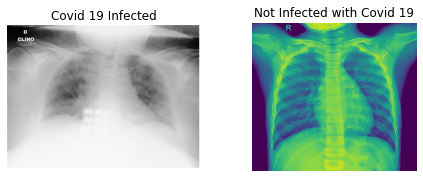

In [8]:
#Plot a sample image from each category
plt.figure(figsize=(20,6))
for ix,i in enumerate(classes):
    f = os.listdir(os.path.join(train_path,i))[0]
    img = mpimg.imread(os.path.join(train_path,i,f))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_map[i])

In [0]:
#Build a Vanilla CNN Model
def image_classifier(nb_classes):
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(299, 299, 3),padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    #model.add(Conv2D(filters=64, kernel_size=(5, 5),padding='valid'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, init='uniform', activation='relu'))

    model.add(Dense(nb_classes, activation='sigmoid'))
    
    return(model)

In [10]:
#Optimizer Adam is used because of Adaptive learning rate
model = image_classifier(nb_classes=2)
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
hist0 = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=5,
                           steps_per_epoch=126//16,validation_steps=30//16,).history



Epoch 1/5
7/7 [==============================] - 8s 1s/step - loss: 7.9992 - acc: 0.5000 - val_loss: 9.0170 - val_acc: 0.4375
Epoch 2/5
7/7 [==============================] - 5s 672ms/step - loss: 7.2979 - acc: 0.5447 - val_loss: 6.8701 - val_acc: 0.5714
Epoch 3/5
7/7 [==============================] - 6s 821ms/step - loss: 8.5876 - acc: 0.4643 - val_loss: 9.0170 - val_acc: 0.4375
Epoch 4/5
7/7 [==============================] - 5s 688ms/step - loss: 6.8290 - acc: 0.5740 - val_loss: 6.8701 - val_acc: 0.5714
Epoch 5/5
7/7 [==============================] - 6s 826ms/step - loss: 8.2841 - acc: 0.4832 - val_loss: 7.0132 - val_acc: 0.5625


# **Transfer Learning**


1.   Tranfer Learning involves using models trained on large data sets such as Imagenets and transfer its knowledge to smaller data sets. Transfer learning is flexible, allowing the use of pre trained models directly as feature extraction preprocessing and integrating into entirely new models 
2.   The basic idea is convolution layers extracts general low level features that are applicable across all images such as edges, patterns etc and later layers identify specific features within an image 



In [0]:
#cretae the base pre trained model
base_model=InceptionV3(weights='imagenet',include_top=False)
x=base_model.output
#Add a Global Average Pooling Layer
x=GlobalAveragePooling2D()(x)


#Lets add a fully connected layer
x=Dense(1024,activation='relu')(x)

#Add a logistic layer  -- lets say we have two classes 
predictions=Dense(2,activation='sigmoid')(x)

#Model we will train
model=Model(inputs=base_model.input,outputs=predictions)


#First only train the top layers which were randomly initialized 
#i.e freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
  layer.trainable=False

#Compile the model
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [28]:
hist1 = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=7,
                           steps_per_epoch=126/16,validation_steps=30/16,).history

Epoch 1/7
8/7 [==============================] - 7s 817ms/step - loss: 0.1548 - acc: 0.9374 - val_loss: 0.9626 - val_acc: 0.7000
Epoch 2/7
8/7 [==============================] - 6s 802ms/step - loss: 0.1477 - acc: 0.9296 - val_loss: 0.5457 - val_acc: 0.8167
Epoch 3/7
8/7 [==============================] - 6s 796ms/step - loss: 0.1131 - acc: 0.9687 - val_loss: 0.2749 - val_acc: 0.9333
Epoch 4/7
8/7 [==============================] - 6s 796ms/step - loss: 0.0945 - acc: 0.9570 - val_loss: 0.2395 - val_acc: 0.9667
Epoch 5/7
8/7 [==============================] - 6s 802ms/step - loss: 0.1284 - acc: 0.9442 - val_loss: 0.6105 - val_acc: 0.8000
Epoch 6/7
8/7 [==============================] - 6s 796ms/step - loss: 0.1083 - acc: 0.9628 - val_loss: 0.3320 - val_acc: 0.8667
Epoch 7/7
8/7 [==============================] - 6s 797ms/step - loss: 0.0499 - acc: 0.9922 - val_loss: 0.2393 - val_acc: 0.9500


In [0]:
#save the weights
model.save_weights("Covid19.h5")